# **Thư viện**

In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# **Dữ liệu**

In [3]:
import pandas as pd

# Đọc file EUR/VND
eur_df = pd.read_csv(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\data\processed\EUR_VND_Exchange_Rate.csv")
eur_df['Date'] = pd.to_datetime(eur_df['Date'])
eur_df = eur_df[['Date', 'Sell']].rename(columns={'Sell': 'EUR_Sell'})

# Đọc file USD/VND
usd_df = pd.read_csv(r"C:\Users\DELL\Downloads\eur-vnd-exchange-rate\data\processed\USD_VND_Exchange_Rate.csv")
usd_df['Date'] = pd.to_datetime(usd_df['Date'])
usd_df = usd_df[['Date', 'Sell']].rename(columns={'Sell': 'USD_Sell'})

# Gộp 2 file theo ngày
merged_df = pd.merge(eur_df, usd_df, on='Date', how='inner')

merged_df.set_index('Date', inplace=True)

print(merged_df.head())

merged_df.to_csv(r"D:\eur-vnd-exchange-rate\data\processed\exchange_rate_merged.csv")

            EUR_Sell  USD_Sell
Date                          
2020-04-01  26506.55   23650.0
2020-04-02  26506.55   23650.0
2020-04-03  25936.23   23530.0
2020-04-04  25936.23   23530.0
2020-04-05  25936.23   23530.0


# **Chọn biến đầu vào**

In [4]:
y = merged_df['EUR_Sell']
exog = merged_df[['USD_Sell']] 

# **Tính dừng**

In [5]:
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -1.671871807232598
p-value: 0.445660109931818
Chuỗi không dừng, cần lấy sai phân


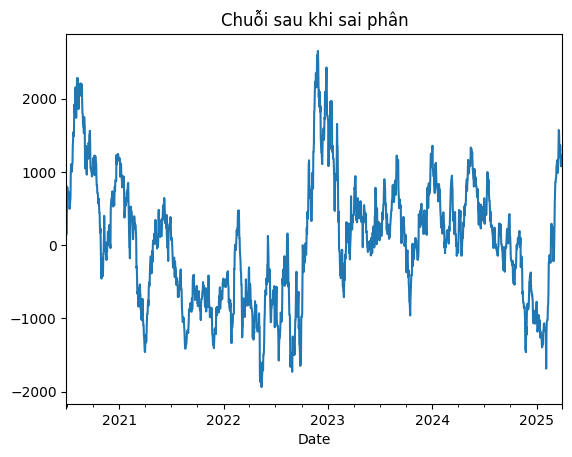

ADF Statistic: -3.391449404969106
p-value: 0.011253837471474815
Chuỗi dừng


In [6]:
y_diff = y.diff(90).dropna()
y_diff.plot(title="Chuỗi sau khi sai phân")
plt.show()

result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

# **ACF và PACF để chọn p, q**

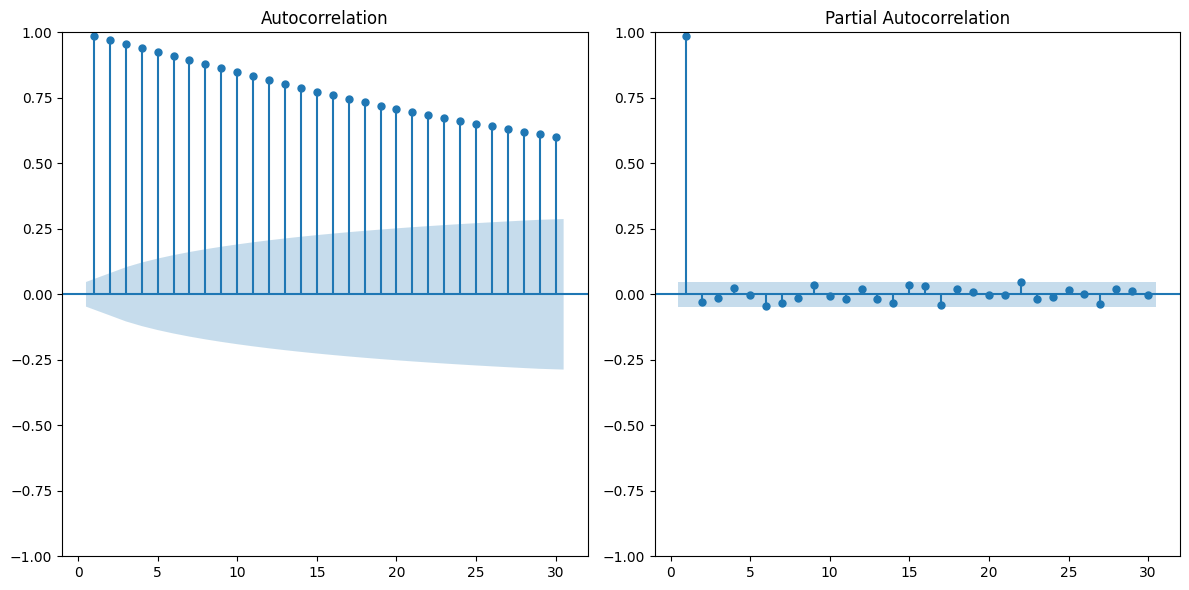

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = plot_acf(y_diff, ax=ax1, lags=30, zero=False)
_ = plot_pacf(y_diff, ax=ax2, lags=30, zero=False)

ax1.set_ylim(-1, 1)
ax2.set_ylim(-1, 1)

plt.tight_layout()
plt.show()


# **SARIMAX**

In [8]:
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

In [9]:
model = SARIMAX(y_train,
                exog=exog_train,
                order=(1, 1, 6),
                seasonal_order=(1, 1, 0, 90),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
# Lưu model
joblib.dump(results, r'C:\Users\DELL\Downloads\eur-vnd-exchange-rate\models\SARIMAX\sarimax_model.pkl')

['C:\\Users\\DELL\\Downloads\\eur-vnd-exchange-rate\\models\\SARIMAX\\sarimax_model.pkl']

# **Đánh giá**

In [ ]:
y_pred = results.predict(start=len(y_train), end=len(y)-1, exog=exog_test)

MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE:.2f}%")

MAE: 492.82721605528764
MSE: 330041.2237350813
RMSE: 574.4921441891797
MAPE: 1.78%


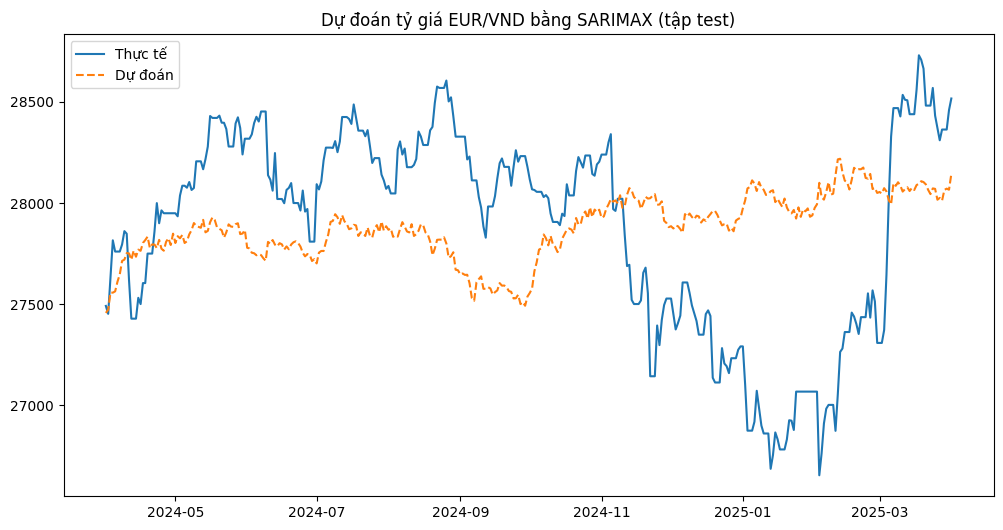

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Thực tế')
plt.plot(y_test.index, y_pred, label='Dự đoán', linestyle='--')
plt.title('Dự đoán tỷ giá EUR/VND bằng SARIMAX (tập test)')
plt.legend()
plt.show()